In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# ****** This code was run on kaggle notebook for PUBG Finish Placement Prediction  ******
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
df = pd.read_csv('../input/train_V2.csv')
# Any results you write to the current directory are saved as output.

['train_V2.csv', 'test_V2.csv', 'sample_submission_V2.csv']


In [2]:
# Dropping ID columns. Not useful for our analysis
df = df.drop(columns = ['Id', 'groupId','matchId'])

In [3]:
# Used to display all columns
pd.set_option('display.max_columns', 500) 
df.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [4]:
# Certain modes have very low number of players
# We are only considering the 6 most popular modes. Dropping 'normal-squad-fpp','crashfpp','normal-duo-fpp','flaretpp','normal-solo-fpp','flarefpp','normal-squad','normal-solo','normal-duo','crashtpp'.
df = df.set_index('matchType')
df = df.drop(['normal-squad-fpp','crashfpp','normal-duo-fpp','flaretpp','normal-solo-fpp','flarefpp','normal-squad','normal-solo','normal-duo','crashtpp' ])
df = df.reset_index()

In [5]:
# Checking correlation amongst all the features. Highly un-correlated features will be removed
import matplotlib.pyplot as plt
corr = df.corr()
corr.style.background_gradient()


,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
assists,1,0.320749,0.381016,0.293719,0.178718,0.229092,-0.290405,0.0409497,0.289653,0.235733,0.259647,-0.00506447,-0.141421,-0.140108,-0.0157262,0.200387,0.114171,0.012137,0.025339,0.00242827,0.0587706,0.303187,0.200232,0.023629,0.305667
boosts,0.320749,1,0.542588,0.367556,0.347165,0.537856,-0.556801,0.00847055,0.526504,0.409361,0.426893,0.0682908,-0.0128702,-0.0122208,0.0235564,0.254074,0.328304,0.037011,0.108672,0.0138445,0.0865186,0.64122,0.437042,-0.00786743,0.636463
damageDealt,0.381016,0.542588,1,0.751865,0.603859,0.346487,-0.690222,0.0520972,0.883154,0.708764,0.571355,0.00812661,-0.0297652,-0.0288387,-8.36382e-05,0.263056,0.146487,0.0561758,0.0389878,0.0119804,0.0829922,0.415061,0.313862,0.0170245,0.450645
DBNOs,0.293719,0.367556,0.751865,1,0.477154,0.267661,-0.563748,0.0436764,0.72688,0.655835,0.458233,-0.0119947,-0.26976,-0.267906,-0.00280877,0.300143,0.104814,0.0370378,0.0180334,0.0712545,0.0606611,0.291889,0.212729,0.0106719,0.284162
headshotKills,0.178718,0.347165,0.603859,0.477154,1,0.201067,-0.477337,0.0250208,0.666665,0.513568,0.451981,-0.00695593,0.0174838,0.0179294,0.00611337,0.153329,0.0811211,0.0178455,0.029792,0.00705399,0.0414409,0.261289,0.189479,0.00434219,0.28264
heals,0.229092,0.537856,0.346487,0.267661,0.201067,1,-0.386412,-0.00250756,0.316061,0.2705,0.263564,0.110821,-0.0617055,-0.0611853,0.0198557,0.237253,0.298133,0.0273613,0.0805092,0.0353688,0.0630639,0.432806,0.317732,-0.0116095,0.430058
killPlace,-0.290405,-0.556801,-0.690222,-0.563748,-0.477337,-0.386412,1,-0.0237081,-0.749421,-0.81267,-0.542635,-0.00954083,0.0111202,0.0131362,-0.015537,-0.270764,-0.235068,-0.0548299,-0.0903094,-0.0374528,-0.0723584,-0.592765,-0.506911,-0.00181547,-0.72091
killPoints,0.0409497,0.00847055,0.0520972,0.0436764,0.0250208,-0.00250756,-0.0237081,1,0.0384478,0.0377495,0.0141931,-0.105283,-0.0459408,-0.043541,-0.975656,0.0119943,-0.0281067,0.00112785,-0.00482285,-0.0394333,-0.00860986,0.00406774,-0.00423676,0.983563,0.0130006
kills,0.289653,0.526504,0.883154,0.72688,0.666665,0.316061,-0.749421,0.0384478,1,0.814002,0.615467,-0.0135341,0.00743443,0.00861445,0.00957837,0.261437,0.121336,0.0643215,0.0418312,0.0139904,0.0826099,0.394503,0.29289,0.00624228,0.431588
killStreaks,0.235733,0.409361,0.708764,0.655835,0.513568,0.2705,-0.81267,0.0377495,0.814002,1,0.515613,-0.027489,-0.0333262,-0.0319201,0.00375876,0.243088,0.0995752,0.0642699,0.0353206,0.0266901,0.063284,0.331427,0.269843,0.00835622,0.377973


In [6]:
# We will now drop uncorrelated features 'killPoints','matchDuration','maxPlace','numGroups','rankPoints','roadKills','swimDistance','vehicleDestroys','killPoints','winPoints'. 
df = df.drop(columns = ['killPoints','matchDuration','maxPlace','numGroups','rankPoints','roadKills','swimDistance','vehicleDestroys','killPoints','winPoints'])

In [7]:
df.head()
# The matchType feature is the only one with 'object' datatype. We will use LabelEncoder() to label encode it.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['matchType'] = le.fit_transform(df['matchType'])

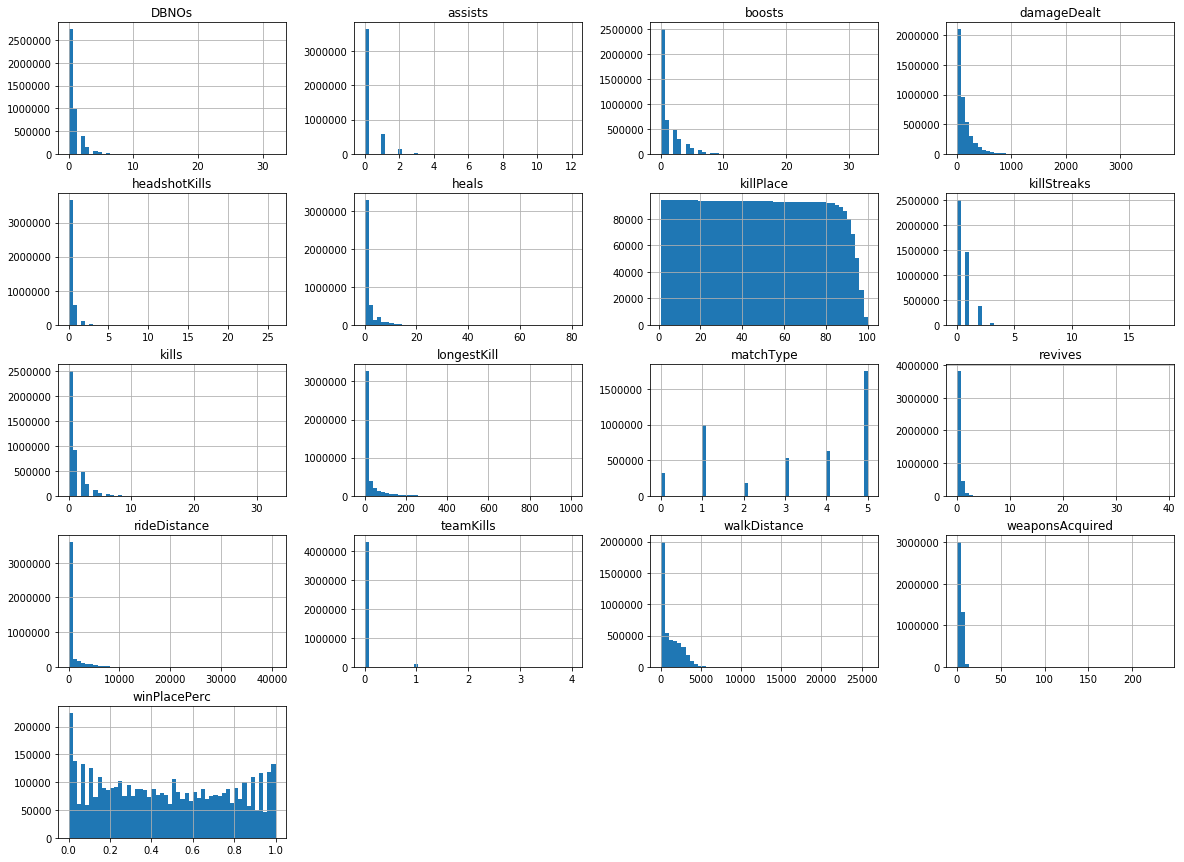

In [8]:
# We are trying to figure out if any of the data has skewness to it. Any skewed data has to be normalised.
# We are also trying to bring down are data between [0,1] so that the model is better able to understand it.
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins = 50, figsize = (20,15))
plt.show()

In [9]:
import numpy as np
df['damageDealt'] = df['damageDealt'].apply(np.cbrt)
df['walkDistance'] = df['walkDistance'].apply(np.cbrt)
df['rideDistance'] = df['rideDistance'].apply(np.cbrt)
df['longestKill'] = df['longestKill'].apply(np.cbrt)


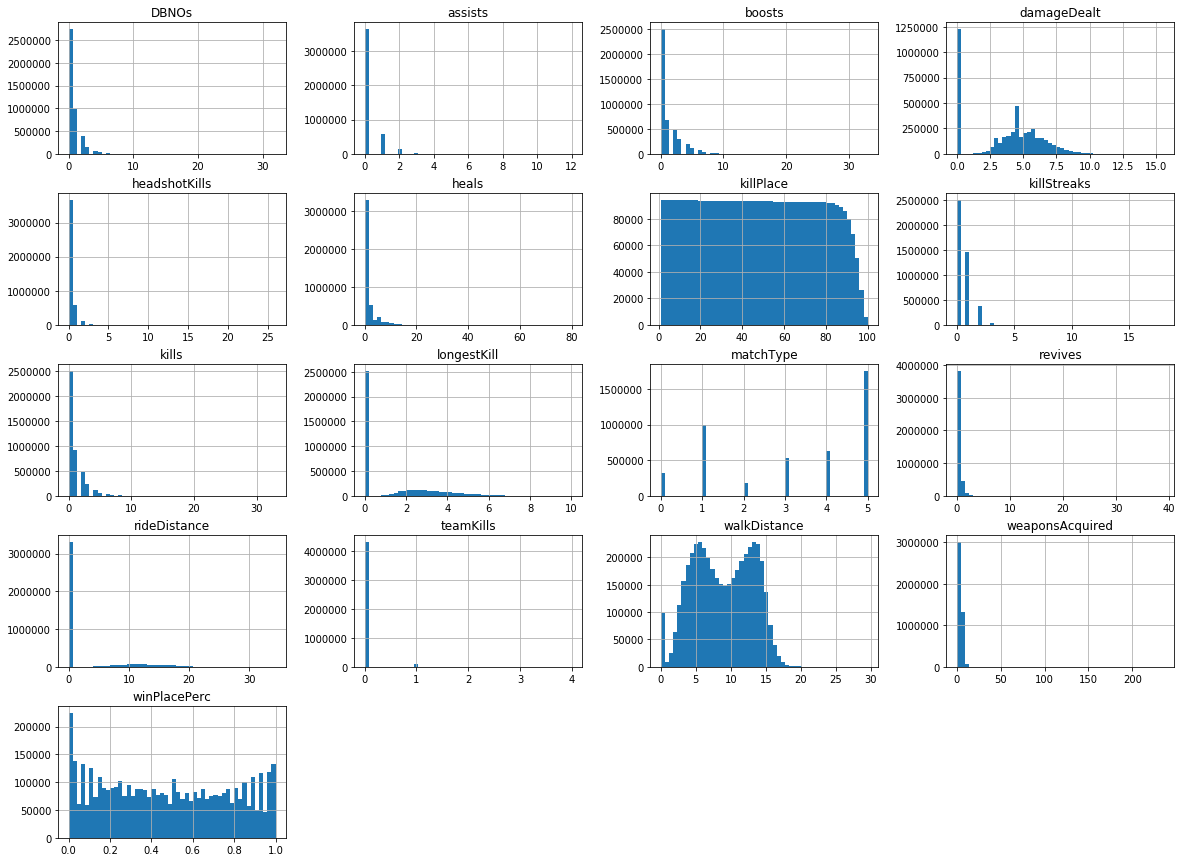

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins = 50, figsize = (20,15))
plt.show()

In [11]:
df['walkDistance'] = df['walkDistance']/np.max(df['walkDistance'])
df['rideDistance'] = df['rideDistance']/np.max(df['rideDistance'])
df['damageDealt'] = df['damageDealt']/np.max(df['damageDealt'])
df['weaponsAcquired'] = df['weaponsAcquired'].apply(np.cbrt)
df['kills'] = df['kills'].apply(np.cbrt)

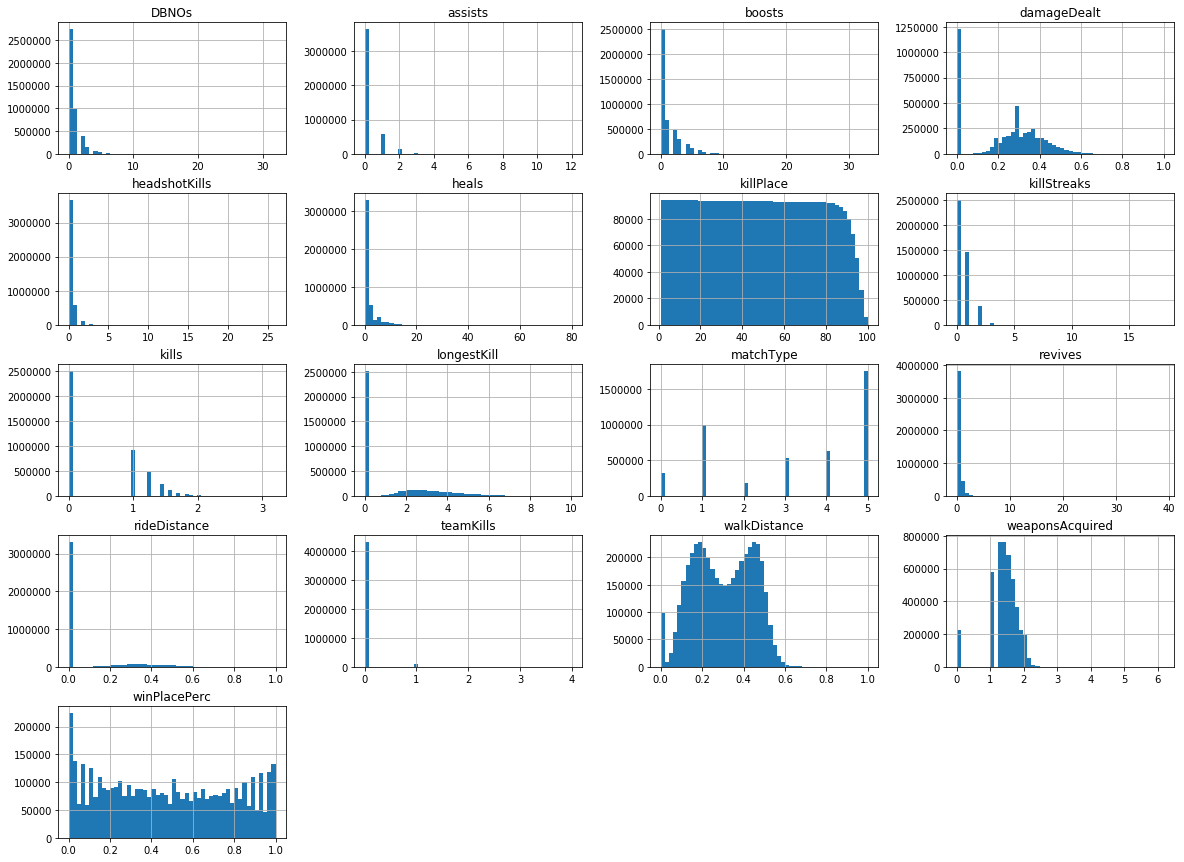

In [12]:
df.hist(bins = 50, figsize = (20,15))
plt.show()

In [13]:
# The killPlace attribute shows what is the players position on the kills leaderboard.
# Since it's a form of ranking from 1-100
# We group them into 10 bands each of width 10
df['killPlaceBand'] = pd.cut(df['killPlace'],10)
df[['killPlaceBand', 'winPlacePerc']].groupby(['killPlaceBand'], as_index = False).mean().sort_values(by = 'killPlaceBand', ascending = True)

,killPlaceBand,winPlacePerc
0,"(0.901, 10.9]",0.805134
1,"(10.9, 20.8]",0.655760
2,"(20.8, 30.7]",0.664373
3,"(30.7, 40.6]",0.428720
4,"(40.6, 50.5]",0.650628
5,"(50.5, 60.4]",0.575462
6,"(60.4, 70.3]",0.375440
7,"(70.3, 80.2]",0.214054
8,"(80.2, 90.1]",0.086561
9,"(90.1, 100.0]",0.017507


In [14]:
df['killPlaceBand'] = le.fit_transform(df['killPlaceBand'])


In [15]:
df = df.drop(columns = 'killPlace')

In [16]:
# The dataset is too big. Any rows which contain missing values are less. So we just dropped them.
df = df.dropna()

In [17]:
# Rather than using a separate test.csv, we split our train data into test and train.
# It's fairly big enough to not cause any issues.
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,train_size = 0.66)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
x_train = train.drop(columns = 'winPlacePerc')
y_train = train['winPlacePerc']
x_test = test.drop(columns = 'winPlacePerc')
y_test = test['winPlacePerc']


In [19]:
# Linear Regressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
l_r = LinearRegression()
l_r.fit(x_train,y_train)
y_pred_l_r = l_r.predict(x_test)
print(l_r.score(x_train,y_train))
print(l_r.score(x_test,y_test))
print(mean_absolute_error(y_test,y_pred_l_r))

0.8380305914836224
0.8372335231353845
0.09348977578743368


In [20]:
# XGBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
xgb = XGBRegressor()
xgb.fit(x_train,y_train)
xgb.score(x_train,y_train)
xgb.score(x_test,y_test)
y_pred_xgb = xgb.predict(x_test)
print(mean_absolute_error(y_test,y_pred_xgb))

0.078347853147614


In [21]:
# Cross Validation
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
xgb = XGBRegressor()
scores = cross_val_score(xgb,x_train,y_train,scoring = 'neg_mean_absolute_error',cv = 10)
print(scores)
print(scores.mean())

[-0.07822864 -0.07843923 -0.07826281 -0.07804275 -0.07821296 -0.07825245
 -0.07827254 -0.07833014 -0.0784237  -0.07814894]
-0.07826141583101756


In [22]:
# Decision tree
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth = 6)
dtr.fit(x_train,y_train)
dtr.score(x_train,y_train)
dtr.score(x_test,y_test)
y_pred_dtr = dtr.predict(x_test)
print(mean_absolute_error(y_test,y_pred_dtr))
print(dtr.score(x_train,y_train))
print(dtr.score(x_test,y_test))

0.08481466342301294
0.8568658351788612
0.8558124088067884


In [23]:
# SGDRegressor
from sklearn import linear_model
sgd = linear_model.SGDRegressor(max_iter=1000)
sgd.fit(x_train,y_train)
print(sgd.score(x_train,y_train))
print(sgd.score(x_test,y_test))
y_pred_sgd = sgd.predict(x_test)
print(mean_absolute_error(y_test,y_pred_sgd))

0.8378771818864945
0.8370938463636537
0.09355333886270993


In [24]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
r_f_r = RandomForestRegressor(n_estimators = 10)
r_f_r.fit(x_train,y_train)
r_f_r.score(x_train,y_train)
y_pred = r_f_r.predict(x_test)
print(mean_absolute_error(y_test,y_pred))
print(r_f_r.score(x_test,y_test))

0.07944571059719265
0.8751921663319983


In [25]:
mae_lr = mean_absolute_error(y_test,y_pred_l_r)
mae_xgb = mean_absolute_error(y_test,y_pred_xgb)
mae_sgd = mean_absolute_error(y_test,y_pred_sgd)
mae_dtr = mean_absolute_error(y_test,y_pred_dtr)
mae_rfr = mean_absolute_error(y_test,y_pred)
                              

In [26]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost Regressor', 'Decision Tree', 
              'Random Forest','Stochastic Gradient Decent'],
    'MAE': [mae_lr,mae_xgb,mae_dtr,mae_rfr,mae_sgd]})
models.sort_values(by='MAE', ascending=True)

,Model,MAE
1,XGBoost Regressor,0.078348
3,Random Forest,0.079446
2,Decision Tree,0.084815
0,Linear Regression,0.093490
4,Stochastic Gradient Decent,0.093553


In [28]:
# XGBoost Regressor gives us the best MAE
# Pickling
import pickle
filename = 'xgb_pickle.sav'
pickle.dump(xgb,open(filename,'wb'))